## Kaggle Retinal Lesions Segmentation

### Train labels

 Loading the dataset

In [40]:
from sklearn.model_selection import train_test_split
from shutil import copy, unpack_archive, rmtree

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [41]:
def reset_path(directory:str):
    """
    Deletes an existing directory and re-creates it

    - directory: path to directory
    """
    if os.path.exists(directory):
        rmtree(directory)
    os.mkdir(directory)

In [42]:
DS_BASE_PATH = 'Data'
DB_PATH = 'DB'
TARGET_LESION = 'microaneurysm'
TARGET_STAGE= 1
reset_path(DB_PATH)

In [43]:
filename = 'retinal-lesions-v20191227'
ARCHIVE_FILE_PATH = os.path.join(DS_BASE_PATH, f'{filename}.zip')

if os.path.exists(os.path.join(DS_BASE_PATH, filename)):
    rmtree(os.path.join(DS_BASE_PATH, filename))
unpack_archive(ARCHIVE_FILE_PATH, DS_BASE_PATH)

# grading_csv_path = os.path.sep.join([DS_BASE_PATH,f'{filename}' ,'dr_grades.csv'])
# grading_orig = pd.read_csv(grading_csv_path)
# grading_orig.dropna()

segmentation_csv_path = os.path.sep.join([DS_BASE_PATH,f'{filename}' ,'segmentation_metadata.csv'])
segmentation_orig = pd.read_csv(segmentation_csv_path)
segmentation_orig.dropna()

# display(grading_orig)
display(segmentation_orig)

,name,microaneurysm,retinal_hemorrhage,hard_exudate,cotton_wool_spots,neovascularization,vitreous_hemorrhage,preretinal_hemorrhage,fibrous_proliferation
0,10037_left,1,1,0,0,0,0,0,0
1,10047_right,1,1,1,0,0,0,0,0
2,1008_right,1,1,1,1,0,0,0,0
3,10091_right,1,1,1,0,0,0,0,0
4,10105_right,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1570,9893_right,1,1,1,0,0,0,0,0
1571,9944_left,1,0,0,0,0,0,0,0
1572,9990_right,1,1,0,0,0,0,0,0
1573,99_right,1,1,1,0,0,0,0,0


**NOTA MILTON**: Se debe de dividir las imágenes en training/val/test por la cantidad de lesiones, no por la cantidad de imágenes

In [44]:
def get_components(im_path:str, cls_num:int):
    # Load the input image in grayscale mode
    img = cv2.imread(im_path, cv2.IMREAD_GRAYSCALE)

    # Apply binary thresholding to convert the image to a binary image
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Get the connected components of the binary image
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=8)


    objects = []

    for i in range(1, num_labels):
        coords = {}

        coords['x0']= int(stats[i, cv2.CC_STAT_LEFT])
        coords['y0']= int(stats[i, cv2.CC_STAT_TOP])
        coords['w']=  int(stats[i, cv2.CC_STAT_WIDTH])
        coords['h']=  int(stats[i, cv2.CC_STAT_HEIGHT])
        
        bndbox = np.array(list(coords.values()))/896
        bndbox = [str(b) for b in bndbox.tolist()]

        label = [str(cls_num)]
        label.extend(bndbox)
        label = ' '.join(label)
        objects.append(label)
    return objects

In [45]:
IMGS_PATH = 'Data/retinal-lesions-v20191227/images_896x896'
LABELS_PATH = 'Data/retinal-lesions-v20191227/lesion_segs_896x896/labels'

annotations = {}
lesion_counts = {}
lesions = list(segmentation_orig.columns[1:])

for mask in os.listdir(LABELS_PATH):
    mask_path = os.path.join(LABELS_PATH, mask)
    im_name, lesion = mask.split('__')
    lesion = lesion.split('.')[0]
    
    if lesion in lesions:
        if im_name not in annotations.keys():
            annotations[im_name] = {}
            lesion_counts[im_name] = {}
        else:
            components = get_components(im_path=mask_path,cls_num=lesions.index(lesion))
            annotations[im_name][lesion] = components
            lesion_counts[im_name][lesion] = len(components)

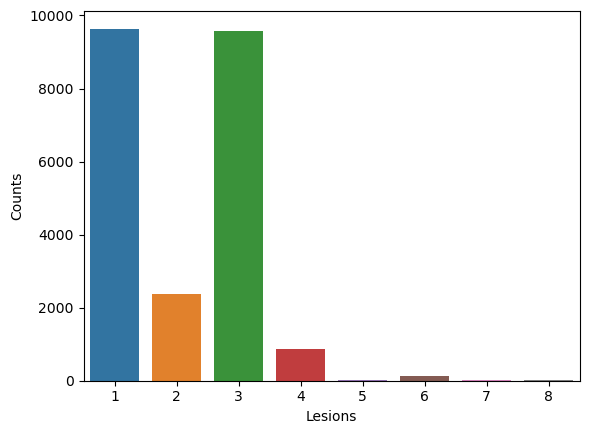

microaneurysm            9637
hard_exudate             2365
retinal_hemorrhage       9583
cotton_wool_spots         876
preretinal_hemorrhage      20
neovascularization        123
fibrous_proliferation      22
vitreous_hemorrhage        18
dtype: int64


In [46]:
lesion_df = pd.DataFrame(lesion_counts).T.fillna(0).astype(int)

abcises = np.arange(1, len(lesion_df.columns)+1)

counts = lesion_df.sum()
sns.barplot(x=abcises, y=counts.values)

plt.xlabel('Lesions')
plt.ylabel('Counts')
plt.show()

print(counts)

In [47]:
image_df = pd.DataFrame(lesion_df[lesion_df[TARGET_LESION]!=0].index, columns=['image'])

In [48]:
train_idx, remain_idx, train_y, remain_y = train_test_split(
    image_df.index,
    image_df['image'],
    train_size=0.8,
    test_size=0.2,
    random_state=42
)

val_idx, test_idx, val_y, test_y = train_test_split(
    remain_idx,
    remain_y,
    train_size=0.5,
    test_size=0.5,
    random_state=42
)

display(image_df.iloc[train_idx].shape)
display(image_df.iloc[val_idx].shape)
display(image_df.iloc[test_idx].shape)

(620, 1)

(78, 1)

(78, 1)

In [49]:
import yaml

# Define the dataset directory and image subdirectories
dataset_root = DB_PATH
train_images_dir = "images/train"
val_images_dir = "images/val"
test_images_dir = "images/test"

# Define the dataset configuration
dataset_config = {
    "path": dataset_root,
    "train": train_images_dir,
    "val": val_images_dir,
    "test": test_images_dir,
    "names": {idx:lesion for idx, lesion in enumerate(lesions)}
}

print(dataset_config)

# Write the configuration to a YAML file
yaml_filepath = os.path.join(DB_PATH,"retinal_lesion.yaml")
with open(yaml_filepath, "w") as f:
    yaml.dump(dataset_config, f, sort_keys=False)

{'path': 'DB', 'train': 'images/train', 'val': 'images/val', 'test': 'images/test', 'names': {0: 'microaneurysm', 1: 'retinal_hemorrhage', 2: 'hard_exudate', 3: 'cotton_wool_spots', 4: 'neovascularization', 5: 'vitreous_hemorrhage', 6: 'preretinal_hemorrhage', 7: 'fibrous_proliferation'}}


In [50]:
def clahe_image(path:str):
    # Load the image
    img = cv2.imread(path)
    # mask = cv2.imread('mask.png', 0)

    # Extract the green plane
    green_plane = img[:, :, 1]

    # Define the FA-CLAHE algorithm
    faclahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(22, 22))

    # Apply the FA-CLAHE algorithm to the green plane
    faclahe_img = faclahe.apply(green_plane)

    # masked_img = cv2.bitwise_and(faclahe_img, faclahe_img, mask=mask)

    cv2.imwrite(path, faclahe_img)

In [51]:
import random

background_df = pd.read_csv('Data/trainLabels.csv')
KAGGLE_PATH = 'Data/resized_train/resized_train'

background_df = background_df.loc[background_df['level']<TARGET_STAGE].sample(len(list(annotations.keys())))
background_list = background_df['image'].to_list()
# print(len(background_list))
background_list = [f for f in background_list if f not in list(annotations.keys())]
existing_imgs = [f.split('.')[0] for f in os.listdir(KAGGLE_PATH)]
background_list = [f for f in background_list if f in existing_imgs]
# print(len(background_list))
# random.shuffle(background_list)
# selected_bg_imgs = background_list[:]

get_bg_content = lambda : {lesion:[''] for lesion in lesions}

selected_bg_imgs = {img:get_bg_content() for img in background_list}

selected_bg_imgs

{'20162_right': {'microaneurysm': [''],
  'retinal_hemorrhage': [''],
  'hard_exudate': [''],
  'cotton_wool_spots': [''],
  'neovascularization': [''],
  'vitreous_hemorrhage': [''],
  'preretinal_hemorrhage': [''],
  'fibrous_proliferation': ['']},
 '35969_left': {'microaneurysm': [''],
  'retinal_hemorrhage': [''],
  'hard_exudate': [''],
  'cotton_wool_spots': [''],
  'neovascularization': [''],
  'vitreous_hemorrhage': [''],
  'preretinal_hemorrhage': [''],
  'fibrous_proliferation': ['']},
 '15103_left': {'microaneurysm': [''],
  'retinal_hemorrhage': [''],
  'hard_exudate': [''],
  'cotton_wool_spots': [''],
  'neovascularization': [''],
  'vitreous_hemorrhage': [''],
  'preretinal_hemorrhage': [''],
  'fibrous_proliferation': ['']},
 '4629_left': {'microaneurysm': [''],
  'retinal_hemorrhage': [''],
  'hard_exudate': [''],
  'cotton_wool_spots': [''],
  'neovascularization': [''],
  'vitreous_hemorrhage': [''],
  'preretinal_hemorrhage': [''],
  'fibrous_proliferation': ['']},


In [52]:
IMG_PATH = 'Data/retinal-lesions-v20191227/images_896x896'

set_paths = [
    (annotations, image_df.iloc[train_idx]['image'].to_list(), IMG_PATH,'.jpg', 'train'),
    (selected_bg_imgs, list(selected_bg_imgs.keys()), KAGGLE_PATH,'.jpeg', 'train'),
    (annotations, image_df.iloc[val_idx]['image'].to_list(), IMG_PATH,'.jpg', 'val'),
    (annotations, image_df.iloc[test_idx]['image'].to_list(), IMG_PATH,'.jpg', 'test')
]

def create_db_path(base:str=DB_PATH, path:str=None):
    
    if path != None:
        path =  os.path.join(base, path)
        if not os.path.exists(path):
            print(f'Creating {path}')
            os.mkdir(path)
        return path
    else:
        print("Empty path, therefore not created")


im_path = create_db_path(path='images')
label_path = create_db_path(path='labels')

for sp in set_paths:
    ds, current_set, orig_path,ext, set_path = sp
    for j, img in enumerate(ds.keys()):
        if j==0:
            print(f'Subset:{set_path}')
        
        if img in current_set:
            
            im_orig_path = os.path.join(orig_path, img + ext)
            im_dest_path = create_db_path(
                                    base=im_path,
                                    path=set_path)
            im_dest_path = os.path.join(im_dest_path, img + ext)
            lb_path = create_db_path(
                                    base=label_path,
                                    path=set_path)
            lb_path = os.path.join(lb_path, img+'.txt')
            
            copy(im_orig_path, im_dest_path)
            print(f'[{j}/{len(annotations.keys())}] {im_dest_path}, {lb_path}')
            clahe_image(im_dest_path)
            
            if TARGET_LESION in ds[img].keys():
                for obj in ds[img][TARGET_LESION]:
                    print(obj)
                    with open(file=lb_path, mode='a') as f:
                        f.write(obj+'\n')



# for sp in set_paths:
#     for j, idx in enumerate(annotations.keys()):
#         current_set, set_path = sp
#         if j==0:
#             print(f'Subset:{set_path}')
#         if idx in current_set:

#             im_orig_path = os.path.join(IMG_PATH, annotations[idx]['name']+ext)
            

#             if not os.path.exists(im_dest_path):
            
            
            

Creating DB/images
Creating DB/labels
Subset:train
Creating DB/images/train
Creating DB/labels/train
[0/1575] DB/images/train/20026_right.jpg, DB/labels/train/20026_right.txt
0 0.3939732142857143 0.3013392857142857 0.026785714285714284 0.018973214285714284
0 0.43080357142857145 0.40401785714285715 0.03236607142857143 0.0234375
0 0.3794642857142857 0.5011160714285714 0.03125 0.0234375
[1/1575] DB/images/train/25783_right.jpg, DB/labels/train/25783_right.txt
0 0.5970982142857143 0.13727678571428573 0.030133928571428572 0.033482142857142856
0 0.6395089285714286 0.16294642857142858 0.04017857142857143 0.03459821428571429
[4/1575] DB/images/train/17409_left.jpg, DB/labels/train/17409_left.txt
0 0.6428571428571429 0.10044642857142858 0.025669642857142856 0.024553571428571428
0 0.5044642857142857 0.11495535714285714 0.029017857142857144 0.0234375
0 0.6037946428571429 0.12165178571428571 0.026785714285714284 0.024553571428571428
0 0.6886160714285714 0.125 0.046875 0.03571428571428571
0 0.76450

In [53]:
from shutil import make_archive

make_archive(
    base_name=f'DB-{TARGET_LESION}',
    format='zip',
    base_dir=DB_PATH
)

'DB-microaneurysm.zip'

In [54]:
# import xmltodict

# path = 'Data/retinal-lesions-v20191227/lesion_segs_896x896/localizacion'
# columns = ['retinal_hemorrhage']
# # lesion_file_dict = {}
# dataset = {}
# counts = {}

# for idx, col in enumerate(segmentation_orig.columns[1:]):
#     files = [f for f in os.listdir(path) if col in f]

#     # display(files)

#     elements = 0

#     for f in files:
#         img = f.split('__')[0]
#         p = os.path.join(path, f)
        
#         if img not in dataset.keys():
#             dataset[img] = {}

#         # if img not in lesion_file_dict.keys():
#         #     lesion_file_dict[img] = {
#         #         'name': img
#         #     }

#         with open(p) as fd:
#             xml = xmltodict.parse(fd.read())
#             lesions = len(xml['annotation']['object'])
            
#             elements += lesions
#             # lesion_file_dict[img][col] = lesions
#             if col in columns:
#                 dataset[img][col] = xml['annotation']['object']
        
#     counts[idx] = {
#         'lesion':col,
#         'count': elements
#     }
#     # display(f'{col}: {elements}')
# display(dataset)
# counts_df = pd.DataFrame(counts).T
# display(counts_df)

In [55]:
# lesion_map = {l:idx for idx, l in enumerate(columns)}

# print(f"Lesion map: {lesion_map}")

# coordinates = []
# yolo_dataset = {}

# for img in dataset.keys():
#     for lesion in dataset[img].keys():
#         if lesion in columns:
#             objs = dataset[img][lesion]
        
#             if not (type(objs) == list):
#                 objs = [objs]
                
#             for obj in objs:
#                 bndbox= obj['bndbox']

#                 bndbox = [int(v) for v in list(bndbox.values())]
#                 # print(bndbox)
#                 xcenter = (bndbox[2]+bndbox[0])/2
#                 ycenter = (bndbox[3]+bndbox[1])/2
#                 width = bndbox[2]-bndbox[0]
#                 height = bndbox[3]-bndbox[1]
                
#                 coordinates.append({
#                     'xcenter': xcenter,
#                     'ycenter': ycenter,
#                     'width': width,
#                     'height': height,
#                 })
#                 bndbox = np.array([xcenter, ycenter, width, height])
#                 # print(bndbox)
#                 bndbox = bndbox / 896
#                 bndbox = [str(b) for b in bndbox.tolist()]

#                 lession_class = lesion_map[lesion]
#                 dp = [str(lession_class)]
#                 dp.extend(bndbox)
#                 dp = ' '.join(dp)

#                 if img not in yolo_dataset.keys():
#                     yolo_dataset[img] = []
                
#                 yolo_dataset[img].append(dp)
# display(yolo_dataset)

In [56]:
# from sklearn.cluster import KMeans
# import seaborn as sns

# hem_df = pd.DataFrame(coordinates, columns=['xcenter', 'ycenter', 'width', 'height'])

# hem_df = hem_df[['width', 'height']] / 896

# # display(hem_df)


# # Perform k-means clustering
# def do_clustering(rand_state: int):
#     k = 10  # Number of clusters

#     kmeans = KMeans(n_clusters=k, n_init=10, random_state=rand_state)
#     kmeans.fit(hem_df)

#     # Add cluster labels to the DataFrame
#     hem_df['cluster'] = kmeans.labels_

#     # Print the centroids
#     centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['width','height'])

#     # Plot the clusters
#     sns.scatterplot(data=hem_df, x='width', y='height', hue='cluster', palette='colorblind')
#     sns.scatterplot(data=centroids, x='width', y='height', color='black', marker='X', s=100)

#     plt.xlabel('width'.title())
#     plt.ylabel('height'.title())
#     plt.title('K-means Clustering')
#     plt.show()

#     print("Centroids:")
#     print(centroids)
#     centroid_description = centroids.describe()
#     print(centroid_description)

#     return centroid_description.loc['mean', 'width':'height'].to_numpy()

# centroid_mean = do_clustering(16)

In [57]:
# centroid_mean

In [58]:
# yolo_df = pd.DataFrame(yolo_dataset.keys(), columns=['image'])
# yolo_df